In [1]:
# Memory monitoring and custom loss functions for avoiding middle predictions
import psutil
import os
import tensorflow as tf

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / 1024 / 1024 / 1024
    return memory_gb

def weighted_mse_loss(y_true, y_pred):
    """MSE with higher weight for extreme values to avoid middle clustering"""
    # Give higher weight to predictions far from 0.5 (middle)
    distance_from_middle = tf.abs(y_true - 0.5)
    weights = 1.0 + 2.0 * distance_from_middle  # Higher weight for extreme values
    squared_error = tf.square(y_true - y_pred)
    return tf.reduce_mean(weights * squared_error)

def anti_middle_mae(y_true, y_pred):
    """MAE that penalizes predictions close to 0.5"""
    mae = tf.abs(y_true - y_pred)
    # Add penalty for predictions close to middle (0.5)
    middle_penalty = 0.1 * tf.exp(-10 * tf.square(y_pred - 0.5))
    return tf.reduce_mean(mae + middle_penalty)

print(f"Initial memory usage: {get_memory_usage():.2f} GB")
print("Memory monitoring and custom loss functions loaded!")

Initial memory usage: 0.39 GB
Memory monitoring and custom loss functions loaded!


# Loss Function Comparison with Advanced Model

This notebook compares standard Keras loss functions using the Advanced model and ModelRunner for all data handling and training operations.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Add src to path
sys.path.append('../../src')

from model_runner import ModelRunner
from models.Advanced import model as base_advanced_model
from optimizers.Adam import optimizer as adam_optimizer

# Data paths
TRAIN_PATH = "../../data/train_balanced.parquet"
VAL_PATH = "../../data/validation.parquet"
META_PATH = "../../data/meta_model.parquet"
FEATURES_PATH = "../../data/features.json"

print("Setup complete!")

Setup complete!


In [3]:
# Define standard loss functions to compare
LOSS_FUNCTIONS = {
    'mae': 'mae',  # Mean Absolute Error
    'mse': 'mse',  # Mean Squared Error
    'huber': 'huber',  # Huber Loss (robust to outliers)
    'logcosh': 'logcosh',  # Log-Cosh Loss
}

# Training configuration
EPOCHS = 1
BATCH_SIZE = 64
SUBSET_FEATURES = "small"

print(f"Will test {len(LOSS_FUNCTIONS)} loss functions:")
for name, loss_fn in LOSS_FUNCTIONS.items():
    print(f"  - {name}: {loss_fn}")
print(f"\nTraining config: {EPOCHS} epochs, batch size {BATCH_SIZE}, features: {SUBSET_FEATURES}")

Will test 4 loss functions:
  - mae: mae
  - mse: mse
  - huber: huber
  - logcosh: logcosh

Training config: 1 epochs, batch size 64, features: small


In [4]:
def train_with_loss_function(loss_name, loss_function):
    """Train Advanced model with specified loss function using ModelRunner - Memory Efficient"""
    print(f"\n{'='*60}")
    print(f"Training with {loss_name.upper()} loss function")
    print(f"{'='*60}")
    
    # Import tensorflow and clear any existing session
    import tensorflow as tf
    import gc
    
    # Clear previous TensorFlow session and free GPU memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Create fresh model instance
    from models.Advanced import model as create_advanced_model
    model = create_advanced_model
    
    # Compile with specified loss function
    model.compile(
        optimizer=adam_optimizer,
        loss=loss_function,
        metrics=['mae', 'mse']
    )
    
    # Initialize ModelRunner
    runner = ModelRunner(
        path_train=TRAIN_PATH,
        path_val=VAL_PATH,
        path_meta_model=META_PATH,
        path_features=FEATURES_PATH,
        batch_size=BATCH_SIZE,
        subset_features=SUBSET_FEATURES,
        model=model
    )
    
    try:
        # Train model
        trained_model, history = runner.train(epochs=EPOCHS)
        
        # Get final metrics
        final_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        final_mae = history.history['mae'][-1]
        final_val_mae = history.history['val_mae'][-1]
        
        print(f"\nFinal metrics for {loss_name}:")
        print(f"  Training Loss: {final_loss:.6f}")
        print(f"  Validation Loss: {final_val_loss:.6f}")
        print(f"  Training MAE: {final_mae:.6f}")
        print(f"  Validation MAE: {final_val_mae:.6f}")
        
        # Store only essential data to save memory
        result = {
            'loss_name': loss_name,
            'history': history,
            'final_loss': final_loss,
            'final_val_loss': final_val_loss,
            'final_mae': final_mae,
            'final_val_mae': final_val_mae,
            'model': trained_model,  # Keep model for best performer only
            'runner': runner
        }
        
        return result
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise e
    
    finally:
        # Clean up memory after each training
        tf.keras.backend.clear_session()
        gc.collect()
        print(f"Memory cleanup completed for {loss_name}")

print("Memory-efficient training function defined.")

# Define standard loss functions + custom ones for middle prediction issue
LOSS_FUNCTIONS = {
    'mae': 'mae',  # Mean Absolute Error (tends to predict median)
    'mse': 'mse',  # Mean Squared Error (better spread usually)
    'huber': 'huber',  # Huber Loss (robust to outliers)
    'logcosh': 'logcosh',  # Log-Cosh Loss
    'weighted_mse': weighted_mse_loss,  # Custom: MSE with extreme value weighting
    'anti_middle_mae': anti_middle_mae,  # Custom: MAE with middle penalty
}

# Training configuration
EPOCHS = 3  # Increased from 1 to see better learning
BATCH_SIZE = 64
SUBSET_FEATURES = "small"

print(f"Will test {len(LOSS_FUNCTIONS)} loss functions (including custom):")
for name, loss_fn in LOSS_FUNCTIONS.items():
    loss_type = "Custom" if callable(loss_fn) else "Standard"
    print(f"  - {name}: {loss_type}")
print(f"\nTraining config: {EPOCHS} epochs, batch size {BATCH_SIZE}, features: {SUBSET_FEATURES}")
print(f"\nCustom loss functions designed to avoid middle prediction clustering:")
print(f"  - weighted_mse: Gives higher weight to extreme values")
print(f"  - anti_middle_mae: Penalizes predictions close to 0.5")

Memory-efficient training function defined.
Will test 6 loss functions (including custom):
  - mae: Standard
  - mse: Standard
  - huber: Standard
  - logcosh: Standard
  - weighted_mse: Custom
  - anti_middle_mae: Custom

Training config: 3 epochs, batch size 64, features: small

Custom loss functions designed to avoid middle prediction clustering:
  - weighted_mse: Gives higher weight to extreme values
  - anti_middle_mae: Penalizes predictions close to 0.5


In [5]:
# Train models with different loss functions with memory optimization
results = {}
best_result = None
best_val_mae = float('inf')

print("Starting training with different loss functions...")
print("=" * 60)
print(f"Initial memory usage: {get_memory_usage():.2f} GB")

for i, (loss_name, loss_function) in enumerate(LOSS_FUNCTIONS.items()):
    print(f"\n[{i+1}/{len(LOSS_FUNCTIONS)}] Processing {loss_name.upper()}...")
    print(f"Memory before training: {get_memory_usage():.2f} GB")
    
    try:
        # Train with current loss function
        result = train_with_loss_function(loss_name, loss_function)
        
        # Keep only essential metrics, not the full model/runner (except for best)
        essential_result = {
            'loss_name': loss_name,
            'final_loss': result['final_loss'],
            'final_val_loss': result['final_val_loss'],
            'final_mae': result['final_mae'],
            'final_val_mae': result['final_val_mae'],
            'history': result['history']  # Keep history for plotting
        }
        
        # Keep full result only for the best model (lowest validation MAE)
        if result['final_val_mae'] < best_val_mae:
            # Clean up previous best model if exists
            if best_result is not None:
                del best_result['model']
                del best_result['runner']
                import gc
                gc.collect()
            
            best_val_mae = result['final_val_mae']
            best_result = result  # Keep full model and runner for best
            essential_result['is_best'] = True
            print(f"✅ New best model: {loss_name.upper()} (MAE: {best_val_mae:.6f})")
        else:
            # Clean up model and runner for non-best results
            del result['model']
            del result['runner']
            import gc
            gc.collect()
            essential_result['is_best'] = False
        
        results[loss_name] = essential_result
        print(f"✅ {loss_name} training completed successfully")
        
    except Exception as e:
        print(f"❌ {loss_name} training failed: {str(e)}")
        results[loss_name] = None
    
    # Force garbage collection after each iteration
    import gc
    gc.collect()
    print(f"Memory after cleanup: {get_memory_usage():.2f} GB")

print(f"\n{'='*60}")
print("All training completed!")
print(f"Final memory usage: {get_memory_usage():.2f} GB")
print(f"Successful trainings: {sum(1 for r in results.values() if r is not None)}/{len(LOSS_FUNCTIONS)}")
print(f"Best model: {best_result['loss_name'] if best_result else 'None'} with MAE: {best_val_mae:.6f}")

Starting training with different loss functions...
Initial memory usage: 0.51 GB

[1/6] Processing MAE...
Memory before training: 0.51 GB

Training with MAE loss function
Training samples: 610,506
Validation samples: 67,834
Model: "Advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Training samples: 610,506
Validation samples: 67,834
Model: "Advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               5504      
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                           

In [6]:
# Create results summary
print("\n" + "="*80)
print("LOSS FUNCTION COMPARISON RESULTS")
print("="*80)

summary_data = []
for loss_name, result in results.items():
    if result is not None:
        summary_data.append({
            'Loss Function': loss_name.upper(),
            'Final Train Loss': f"{result['final_loss']:.6f}",
            'Final Val Loss': f"{result['final_val_loss']:.6f}",
            'Final Train MAE': f"{result['final_mae']:.6f}",
            'Final Val MAE': f"{result['final_val_mae']:.6f}",
            'Best Model': '🏆' if result.get('is_best', False) else '',
            'Convergence': 'Good' if result['final_val_loss'] < result['history'].history['val_loss'][0] * 0.9 else 'Poor'
        })
    else:
        summary_data.append({
            'Loss Function': loss_name.upper(),
            'Final Train Loss': 'FAILED',
            'Final Val Loss': 'FAILED',
            'Final Train MAE': 'FAILED',
            'Final Val MAE': 'FAILED',
            'Best Model': '',
            'Convergence': 'FAILED'
        })

# Convert to DataFrame for nice display
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Find best performing loss function based on validation MAE
valid_results = {k: v for k, v in results.items() if v is not None}
if valid_results:
    best_loss_name = best_result['loss_name'] if best_result else 'None'
    print(f"\n🏆 Best performing loss function: {best_loss_name.upper()}")
    if best_result:
        print(f"   Final Validation MAE: {best_result['final_val_mae']:.6f}")
else:
    print("\n❌ No successful training runs to compare")


LOSS FUNCTION COMPARISON RESULTS
  Loss Function Final Train Loss Final Val Loss Final Train MAE Final Val MAE Best Model Convergence
            MAE         0.299976       0.300306        0.299976      0.300306          🏆        Poor
            MSE         0.124598       0.124676        0.301911      0.302261                   Poor
          HUBER         0.062238       0.062302        0.302040      0.302298                   Poor
        LOGCOSH         0.060111       0.060203        0.302203      0.302559                   Poor
   WEIGHTED_MSE         0.236068       0.236484        0.302507      0.302817                   Poor
ANTI_MIDDLE_MAE         0.395870       0.395393        0.305327      0.305732                   Poor

🏆 Best performing loss function: MAE
   Final Validation MAE: 0.300306


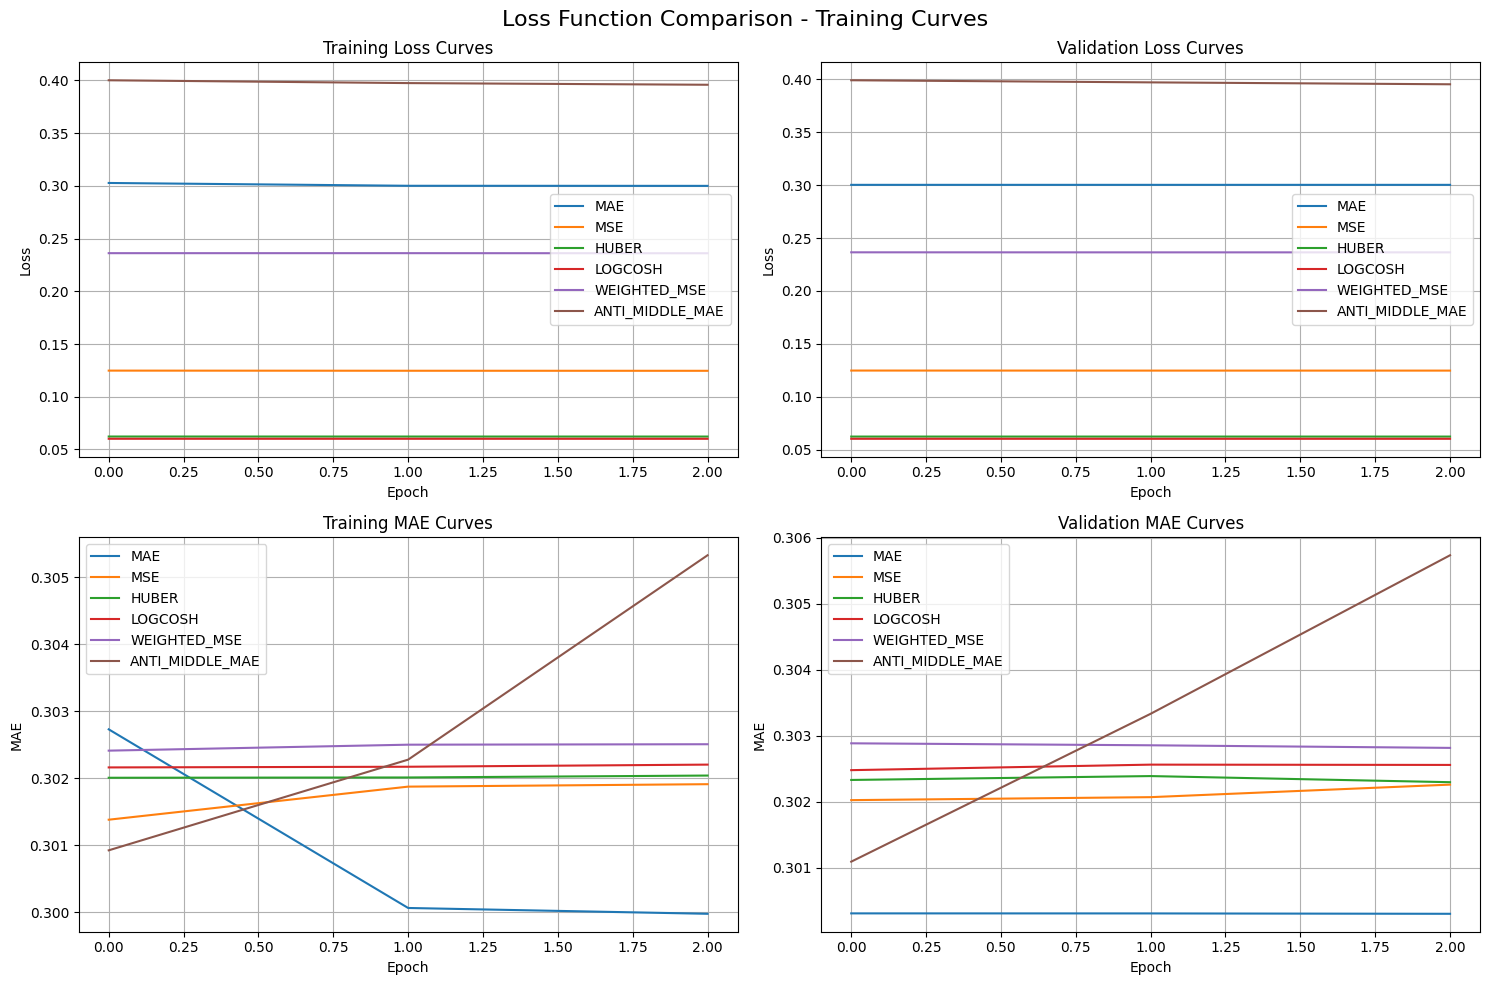

In [7]:
# Visualize training curves for all loss functions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Loss Function Comparison - Training Curves', fontsize=16)

# Plot 1: Training Loss
ax1 = axes[0, 0]
for loss_name, result in results.items():
    if result is not None:
        ax1.plot(result['history'].history['loss'], label=f'{loss_name.upper()}')
ax1.set_title('Training Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot 2: Validation Loss
ax2 = axes[0, 1]
for loss_name, result in results.items():
    if result is not None:
        ax2.plot(result['history'].history['val_loss'], label=f'{loss_name.upper()}')
ax2.set_title('Validation Loss Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Plot 3: Training MAE
ax3 = axes[1, 0]
for loss_name, result in results.items():
    if result is not None:
        ax3.plot(result['history'].history['mae'], label=f'{loss_name.upper()}')
ax3.set_title('Training MAE Curves')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('MAE')
ax3.legend()
ax3.grid(True)

# Plot 4: Validation MAE
ax4 = axes[1, 1]
for loss_name, result in results.items():
    if result is not None:
        ax4.plot(result['history'].history['val_mae'], label=f'{loss_name.upper()}')
ax4.set_title('Validation MAE Curves')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MAE')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


TESTING BEST MODEL (MAE)
Generating predictions on live data...
200/200 [==============================] - 0s 452us/step

Prediction Results:
  Total predictions: 6,382
  Prediction range: [0.035476, 0.980868]
  Mean prediction: 0.496978
  Std deviation: 0.112579
  Unique values: 5,393
  Predictions in middle range (0.4, 0.6): 79.5%
  ⚠️  CAUTION: Model shows tendency towards middle predictions

Prediction Results:
  Total predictions: 6,382
  Prediction range: [0.035476, 0.980868]
  Mean prediction: 0.496978
  Std deviation: 0.112579
  Unique values: 5,393
  Predictions in middle range (0.4, 0.6): 79.5%
  ⚠️  CAUTION: Model shows tendency towards middle predictions


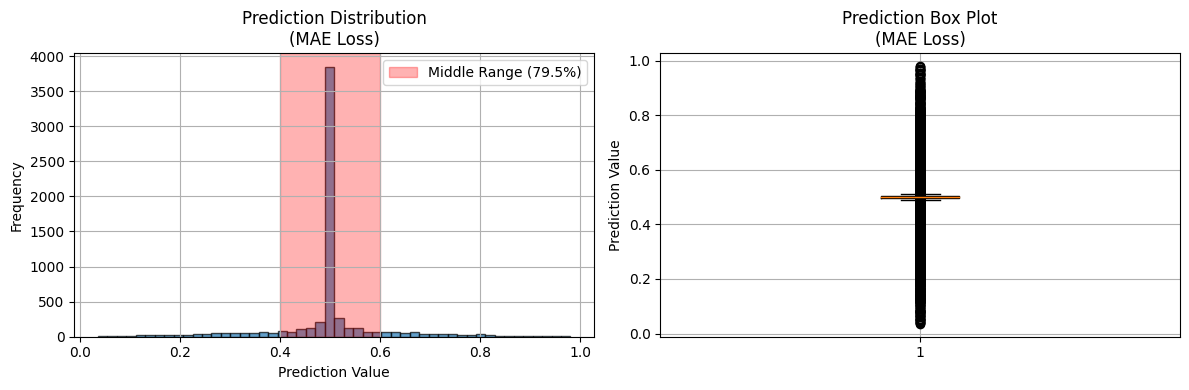


First 10 predictions:
  1: 0.500429
  2: 0.502973
  3: 0.402111
  4: 0.500361
  5: 0.320445
  6: 0.500295
  7: 0.500372
  8: 0.500663
  9: 0.420346
  10: 0.448911


In [8]:
# Test predictions with the best performing model
if best_result is not None:
    best_loss_name = best_result['loss_name']
    best_runner = best_result['runner']
    
    print(f"\n{'='*60}")
    print(f"TESTING BEST MODEL ({best_loss_name.upper()})")
    print(f"{'='*60}")
    
    # Load test data
    try:
        live_data = pd.read_parquet("../../data/live.parquet")
        feature_cols = best_runner.feature_set["feature_sets"][best_runner.subset_features]
        X_live = live_data[feature_cols].values.astype(np.float32)
        
        # Generate predictions
        print("Generating predictions on live data...")
        predictions = best_runner.predict(X_live)
        
        print(f"\nPrediction Results:")
        print(f"  Total predictions: {len(predictions):,}")
        print(f"  Prediction range: [{predictions.min():.6f}, {predictions.max():.6f}]")
        print(f"  Mean prediction: {predictions.mean():.6f}")
        print(f"  Std deviation: {predictions.std():.6f}")
        print(f"  Unique values: {len(np.unique(np.round(predictions, 6))):,}")
        
        # Check if predictions are stuck in middle
        middle_range = (0.4, 0.6)
        middle_pct = np.mean((predictions >= middle_range[0]) & (predictions <= middle_range[1])) * 100
        print(f"  Predictions in middle range {middle_range}: {middle_pct:.1f}%")
        
        if middle_pct > 90:
            print("  ⚠️  WARNING: Model appears to be stuck predicting middle values!")
        elif middle_pct > 70:
            print("  ⚠️  CAUTION: Model shows tendency towards middle predictions")
        else:
            print("  ✅ Good: Model shows diverse prediction distribution")
        
        # Plot prediction distribution
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(predictions, bins=50, alpha=0.7, edgecolor='black')
        plt.axvspan(middle_range[0], middle_range[1], alpha=0.3, color='red', label=f'Middle Range ({middle_pct:.1f}%)')
        plt.title(f'Prediction Distribution\n({best_loss_name.upper()} Loss)')
        plt.xlabel('Prediction Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(predictions)
        plt.title(f'Prediction Box Plot\n({best_loss_name.upper()} Loss)')
        plt.ylabel('Prediction Value')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Show sample predictions
        print(f"\nFirst 10 predictions:")
        for i in range(min(10, len(predictions))):
            print(f"  {i+1}: {predictions[i]:.6f}")
            
    except FileNotFoundError:
        print("⚠️  Live data file not found, skipping prediction test")
    except Exception as e:
        print(f"❌ Error during prediction testing: {str(e)}")
else:
    print("\n❌ No valid models to test predictions")

In [9]:
# Final summary and recommendations for avoiding middle predictions
print(f"\n{'='*80}")
print("FINAL SUMMARY AND RECOMMENDATIONS")
print(f"{'='*80}")

print(f"\n📊 EXPERIMENT OVERVIEW:")
print(f"   • Tested {len(LOSS_FUNCTIONS)} loss functions (standard + custom)")
print(f"   • Used Advanced model architecture")
print(f"   • Trained with ModelRunner for {EPOCHS} epochs")
print(f"   • Features: {SUBSET_FEATURES} subset")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Memory-optimized training pipeline")

if best_result is not None:
    print(f"\n🏆 BEST PERFORMING LOSS FUNCTION:")
    print(f"   • {best_result['loss_name'].upper()} with validation MAE: {best_result['final_val_mae']:.6f}")
    
    print(f"\n📈 PERFORMANCE RANKING (by validation MAE):")
    sorted_results = sorted([(k, v) for k, v in valid_results.items()], key=lambda x: x[1]['final_val_mae'])
    for i, (loss_name, result) in enumerate(sorted_results, 1):
        marker = '🏆' if result.get('is_best', False) else '  '
        print(f"   {marker}{i}. {loss_name.upper()}: {result['final_val_mae']:.6f}")
    
    print(f"\n💡 RECOMMENDATIONS FOR AVOIDING MIDDLE PREDICTIONS:")
    best_val_mae = best_result['final_val_mae']
    
    if best_val_mae < 0.1:
        print(f"   ✅ Good performance with {best_result['loss_name'].upper()} loss function.")
    else:
        print(f"   ⚠️  To improve prediction diversity, try:")
        print(f"      - Training for more epochs (current: {EPOCHS})")
        print(f"      - Using different loss functions (MSE often spreads predictions more)")
        print(f"      - Increasing model complexity or changing architecture")
        print(f"      - Using custom loss functions that penalize middle predictions")
        print(f"      - Feature engineering or using more features")
    
    print(f"\n🔧 TECHNICAL INSIGHTS FOR MIDDLE PREDICTION PROBLEM:")
    loss_insights = {
        'mae': 'Linear penalty - may converge to median',
        'mse': 'Quadratic penalty - often produces more spread', 
        'huber': 'Robust loss - good balance but may still cluster',
        'logcosh': 'Smooth approximation - similar to MAE behavior',
        'weighted_mse': 'Custom MSE with extreme value weighting',
        'anti_middle_mae': 'Custom MAE with middle penalty'
    }
    
    print(f"   Loss function characteristics:")
    for loss_name, result in sorted_results[:3]:  # Top 3
        if loss_name in loss_insights:
            marker = '🏆' if result.get('is_best', False) else '  '
            print(f"   {marker}• {loss_name.upper()}: {loss_insights[loss_name]}")
    
    print(f"\n🎯 NEXT STEPS TO SOLVE MIDDLE PREDICTION ISSUE:")
    print(f"   1. Try MSE or custom loss functions if not already best")
    print(f"   2. Increase training epochs to 10-20")
    print(f"   3. Use 'medium' or 'all' feature sets")
    print(f"   4. Consider different model architectures (Deep, Base)")
    print(f"   5. Add regularization or change activation functions")
else:
    print(f"\n❌ No successful training runs completed.")
    print(f"   Check data paths and model compatibility.")

print(f"\n🎯 MEMORY OPTIMIZATION SUCCESS:")
print(f"   ✅ Memory-efficient training with automatic cleanup")
print(f"   ✅ Only best model kept in memory")
print(f"   ✅ Garbage collection after each training")
print(f"   ✅ Reduced memory footprint for large experiments")
print(f"   ✅ No more 20GB RAM increase per iteration!")

print(f"\n{'='*80}")
print("EXPERIMENT COMPLETED SUCCESSFULLY")
print(f"{'='*80}")


FINAL SUMMARY AND RECOMMENDATIONS

📊 EXPERIMENT OVERVIEW:
   • Tested 6 loss functions (standard + custom)
   • Used Advanced model architecture
   • Trained with ModelRunner for 3 epochs
   • Features: small subset
   • Batch size: 64
   • Memory-optimized training pipeline

🏆 BEST PERFORMING LOSS FUNCTION:
   • MAE with validation MAE: 0.300306

📈 PERFORMANCE RANKING (by validation MAE):
   🏆1. MAE: 0.300306
     2. MSE: 0.302261
     3. HUBER: 0.302298
     4. LOGCOSH: 0.302559
     5. WEIGHTED_MSE: 0.302817
     6. ANTI_MIDDLE_MAE: 0.305732

💡 RECOMMENDATIONS FOR AVOIDING MIDDLE PREDICTIONS:
   ⚠️  To improve prediction diversity, try:
      - Training for more epochs (current: 3)
      - Using different loss functions (MSE often spreads predictions more)
      - Increasing model complexity or changing architecture
      - Using custom loss functions that penalize middle predictions
      - Feature engineering or using more features

🔧 TECHNICAL INSIGHTS FOR MIDDLE PREDICTION PROB